# Baseline
- Try to classify investment opportunities (buy/sell) for upcoming IPO
- No NLP or fancy models
- Raw IPO listing data

In [1]:
#core
%matplotlib inline
import pandas as pd
import glob
import nasdaq
import ml
from pathlib import Path

# Load NASDAQ IPO Performace

In [2]:
#load and sort by date priced
df = pd.read_csv('../Datasets/0 ipo listings.csv', index_col='Symbol')
df['Date Priced'] = pd.to_datetime(df['Date Priced'], format='%Y-%m-%d')
df.sort_values(by='Date Priced', inplace=True)

### Preprocessing

In [3]:
#transform company name 
df.insert(0, 'Name Length', df['Company Name'].str.len())
df.insert(0, 'Name Words', df['Company Name'].str.split(' ').map(lambda x: len(x)))
df.drop(['Company Name'], axis=1, inplace=True)

#add quarter
df.insert(0, 'Q', df['Date Priced'].map(lambda x: pd.Period(x,'Q').quarter))

#add month
df.insert(0, 'Month', df['Date Priced'].dt.month)

df.drop(['Date Priced'], axis=1, inplace=True)

In [4]:
#encode market
df['Market'] = ml.encode(df, 'Market')

In [5]:
#to one hot encoding
df = pd.concat([pd.get_dummies(df['Market']).add_prefix('MKT'), df], axis=1)
df = pd.concat([pd.get_dummies(df['Month']).add_prefix('M'), df], axis=1)
df = pd.concat([pd.get_dummies(df['Q']).add_prefix('Q'), df], axis=1)
df.drop(['Market', 'Month', 'Q'], axis=1, inplace=True)

In [6]:
df.head(3)

,Q1,Q2,Q3,Q4,M1,M2,M3,M4,M5,M6,...,MKT12,Name Words,Name Length,Offer Amount,Price,Shares,1D,1W,1M,3M
Symbol,,,,,,,,,,,,,,,,,,,,,
WQNI,1,0,0,0,0,1,0,0,0,0,...,0,2,9,35750000,13.0,2750000,-0.129856,-0.296122,0.088818,-0.667432
BBGI,1,0,0,0,0,1,0,0,0,0,...,0,4,27,106175000,15.5,6850000,-0.058333,-0.133333,-0.175000,-0.250000
UTSI,1,0,0,0,0,0,1,0,0,0,...,0,3,24,180000000,18.0,10000000,0.512195,0.448171,1.042683,-0.134146


In [7]:
#standardize
cols_to_standardize = ['Name Words', 'Name Length', 'Offer Amount', 'Price', 'Shares']
df[cols_to_standardize] = ml.standardize(df[cols_to_standardize])

In [8]:
#save for later improvements
df.to_csv('../Datasets/1 baseline.csv', index=True, index_label='Symbol')

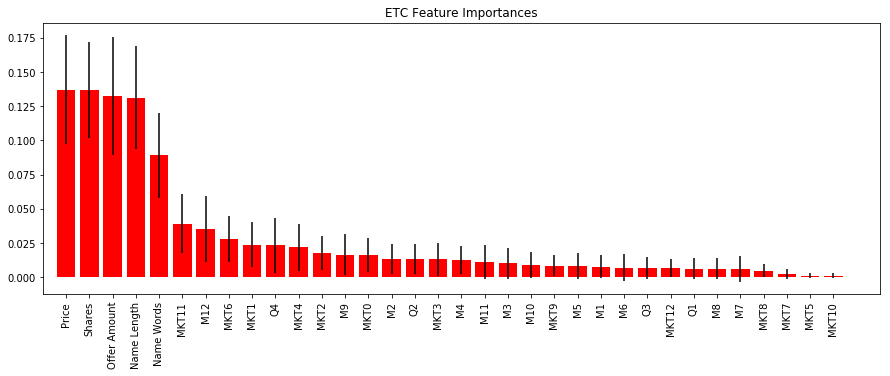

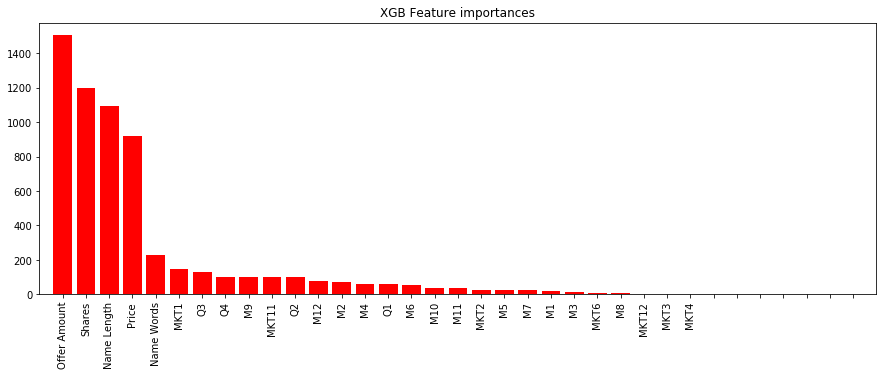

In [9]:
#feature importance
indices = ml.show_feature_importance(df, '3M')

In [10]:
#feature selection
df = ml.select_features(indices.shape[0], indices, df)

['Name Words', 'Name Length', 'Offer Amount', 'Price', 'Shares']


C:\Users\Void\Anaconda3\lib\site-packages\matplotlib\cbook\deprecation.py:106: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)


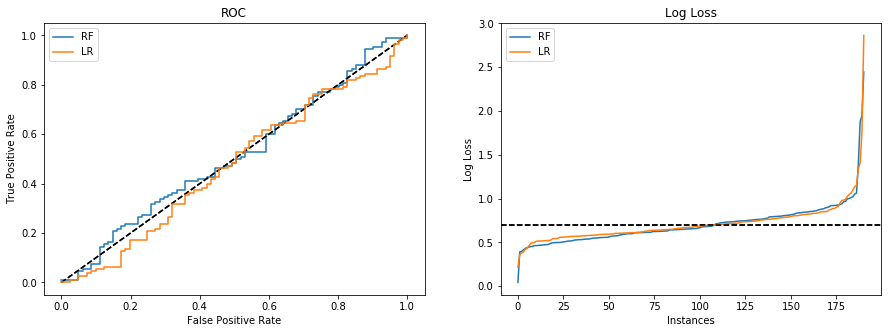

1D        1W        1M        3M
AUC      LR  0.479237  0.479237  0.479237  0.479237
         RF  0.512065  0.512065  0.512065  0.512065
f1       LR  0.696864  0.696864  0.696864  0.696864
         RF  0.695971  0.695971  0.695971  0.695971
log loss LR  0.708928  0.708928  0.708928  0.708928
         RF    0.7011    0.7011    0.7011    0.7011

In [11]:
#as expected the results are poor
ml.run_ml_flow(df)